In [1]:
from lightkurve import KeplerTargetPixelFile, KeplerLightCurveFile
from transit_periodogram import transit_periodogram

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
target = 'KOI-217'

In [8]:
%%capture
tpfs = []
lc = []
qRange = [1,17]
for q in range(qRange[0],qRange[1]):
    try:
        tpfs.append(KeplerTargetPixelFile.from_archive(target, quarter=q))
        lc.append(KeplerLightCurveFile.from_archive(target, quarter=q))
    except:
        continue

In [9]:
quarter = 13

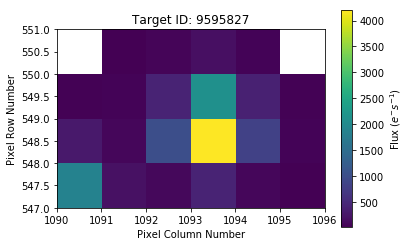

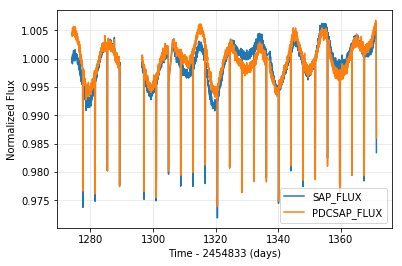

In [10]:
tpfs[quarter].plot()
lc[quarter].plot()

In [11]:
%%capture
lcs = KeplerLightCurveFile.from_archive(target, quarter=qRange[0]).PDCSAP_FLUX
lcsNorm = KeplerLightCurveFile.from_archive(target, quarter=qRange[0]).PDCSAP_FLUX.normalize()
for q in range(qRange[0]+1,qRange[1]):
    try:
        lcs = lcs.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX)
        lcsNorm = lcsNorm.append(KeplerLightCurveFile.from_archive(target, quarter=q).PDCSAP_FLUX.normalize())
        
    except:
        continue

Text(0.5,1,'All Quarters Normalized')

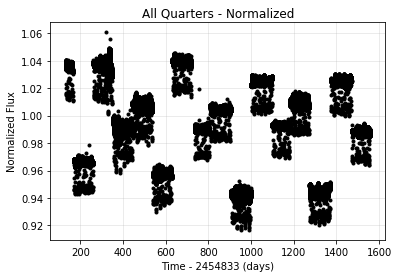

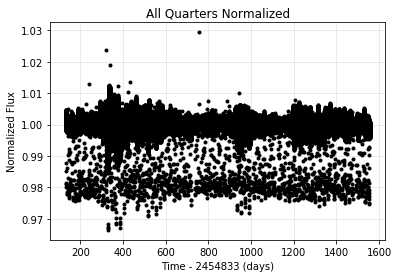

In [13]:
lcs.plot(marker='.',linestyle='none');
plt.title('All Quarters - Normalized')

lcsNorm.plot(marker='.',linestyle='none');
plt.title('All Quarters Normalized')

In [14]:
pipeline_lc = tpfs[0].to_lightcurve().flatten()
for tpf in tpfs:
    pipeline_lc = pipeline_lc.append(tpf.to_lightcurve().flatten())
    
pipeline_lc = pipeline_lc.remove_nans().remove_outliers()

/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:304: RuntimeWarning: invalid value encountered in true_divide
  flatten_lc.flux = flatten_lc.flux / trend_signal
/anaconda3/lib/python3.6/site-packages/lightkurve/lightcurve.py:305: RuntimeWarning: invalid value encountered in true_divide
  flatten_lc.flux_err = flatten_lc.flux_err / trend_signal


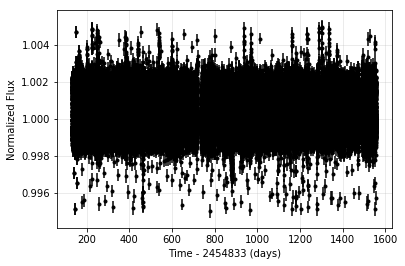

In [15]:
pipeline_lc.plot(fmt='.')

In [17]:
minPer=3
maxPer=5
timeStep = 0.0001
periods = np.arange(minPer, maxPer, timeStep)
durations = np.arange(0.005, 0.3, 0.001)
power, _, _, _, _, _, _ = transit_periodogram(time= pipeline_lc.time,
                                              flux=pipeline_lc.flux,
                                              flux_err= pipeline_lc.flux_err,
                                              periods=periods,
                                              durations=durations)
bestPer = periods[np.argmax(power)]

In [18]:
print('Best Fit Period: {} days'.format(bestPer))

Best Fit Period: 3.90510000000191 days


Text(0.5,1,'BLS Periodogram')

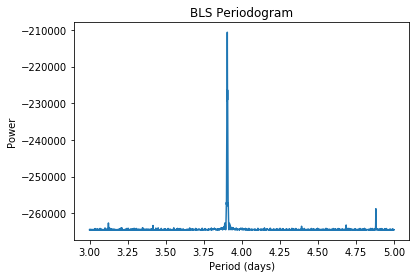

In [20]:
timeStamp = int((maxPer-minPer)/(timeStep))

powerTime = np.linspace(minPer,maxPer,timeStamp)
plt.plot(powerTime,power)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('BLS Periodogram')

(-0.15, 0.15)

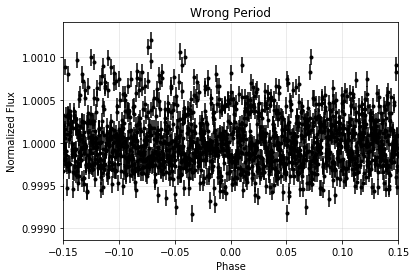

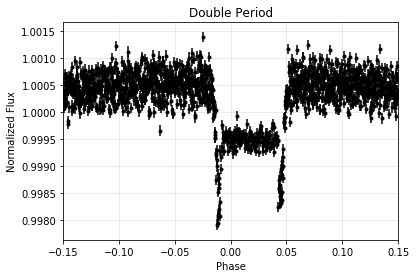

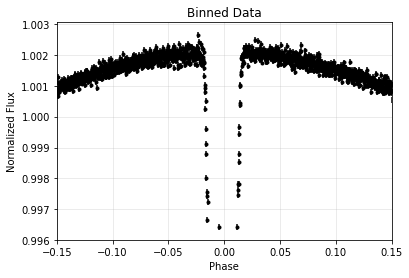

In [21]:
pipeline_lc.fold(period=2.0, phase=0.165).bin().plot(fmt='.');
plt.title('Wrong Period')
plt.xlim(-0.15,0.15)

pipeline_lc.fold(period=.5*bestPer, phase=0.31).bin().plot(fmt='.');
plt.title('Double Period')
plt.xlim(-0.15,0.15)

pipeline_lc.fold(period=bestPer, phase=0.165).bin().plot(fmt='.');
plt.title('Binned Data')
plt.xlim(-0.15,0.15)

(0.96, 1.03)

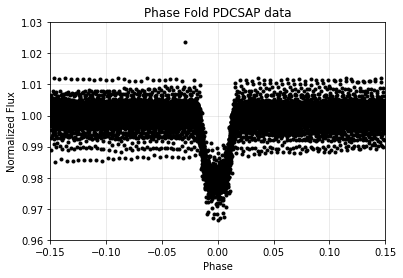

In [25]:
lcsNorm.fold(period=bestPer, phase=0.165).plot(marker='.',linestyle='none');
plt.xlim(-0.15,0.15)
plt.title('Phase Fold PDCSAP data')
plt.ylim(0.96,1.03)